In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import random
import datetime
import torch
import torch.nn as nn
from torch.nn import Sequential
import torch.nn.functional as F
#from torch_pconv import PConv2d
import glob
import time
import subprocess
import os
import pickle

In [2]:
split_root = '/glade/derecho/scratch/jstarfeldt/autoencoder/autoencoder_train_split_files'
standard_root = '/glade/derecho/scratch/jstarfeldt/autoencoder/standard_arrays'
dataset_root = '/glade/derecho/scratch/jstarfeldt/urban_heat_dataset'

In [3]:
np.random.seed(53)
torch.manual_seed(53)
random.seed(53)

## Data Visualization

In [4]:
dsL = xr.open_dataset(dataset_root+'/DMV/processed_Landsat/Landsat_Sentinel_image_DMV_202201081546.nc')
dsL

<xarray.Dataset> Size: 936MB
Dimensions:                    (y: 3000, x: 3000)
Coordinates:
  * x                          (x) float64 24kB 2.92e+05 2.92e+05 ... 3.82e+05
  * y                          (y) float64 24kB 4.282e+06 ... 4.372e+06
    datetime                   object 8B ...
Data variables: (12/14)
    Landsat_cloud_mask         (y, x) object 72MB ...
    Landsat_blue_reflectance   (y, x) float64 72MB ...
    Landsat_green_reflectance  (y, x) float64 72MB ...
    Landsat_red_reflectance    (y, x) float64 72MB ...
    Landsat_NIR_reflectance    (y, x) float64 72MB ...
    Landsat_SWIR1_reflectance  (y, x) float64 72MB ...
    ...                         ...
    Sentinel1_VV               (y, x) float64 72MB ...
    Sentinel1_VH               (y, x) float64 72MB ...
    Sentinel1_HH               (y, x) float64 72MB ...
    Sentinel1_HV               (y, x) float64 72MB ...
    Sentinel1_angle            (y, x) float64 72MB ...
    spatial_ref                int32 4B ...
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

Text(0.5, 0.98, 'Visualization of Landsat Bands, DMV 202201081546')

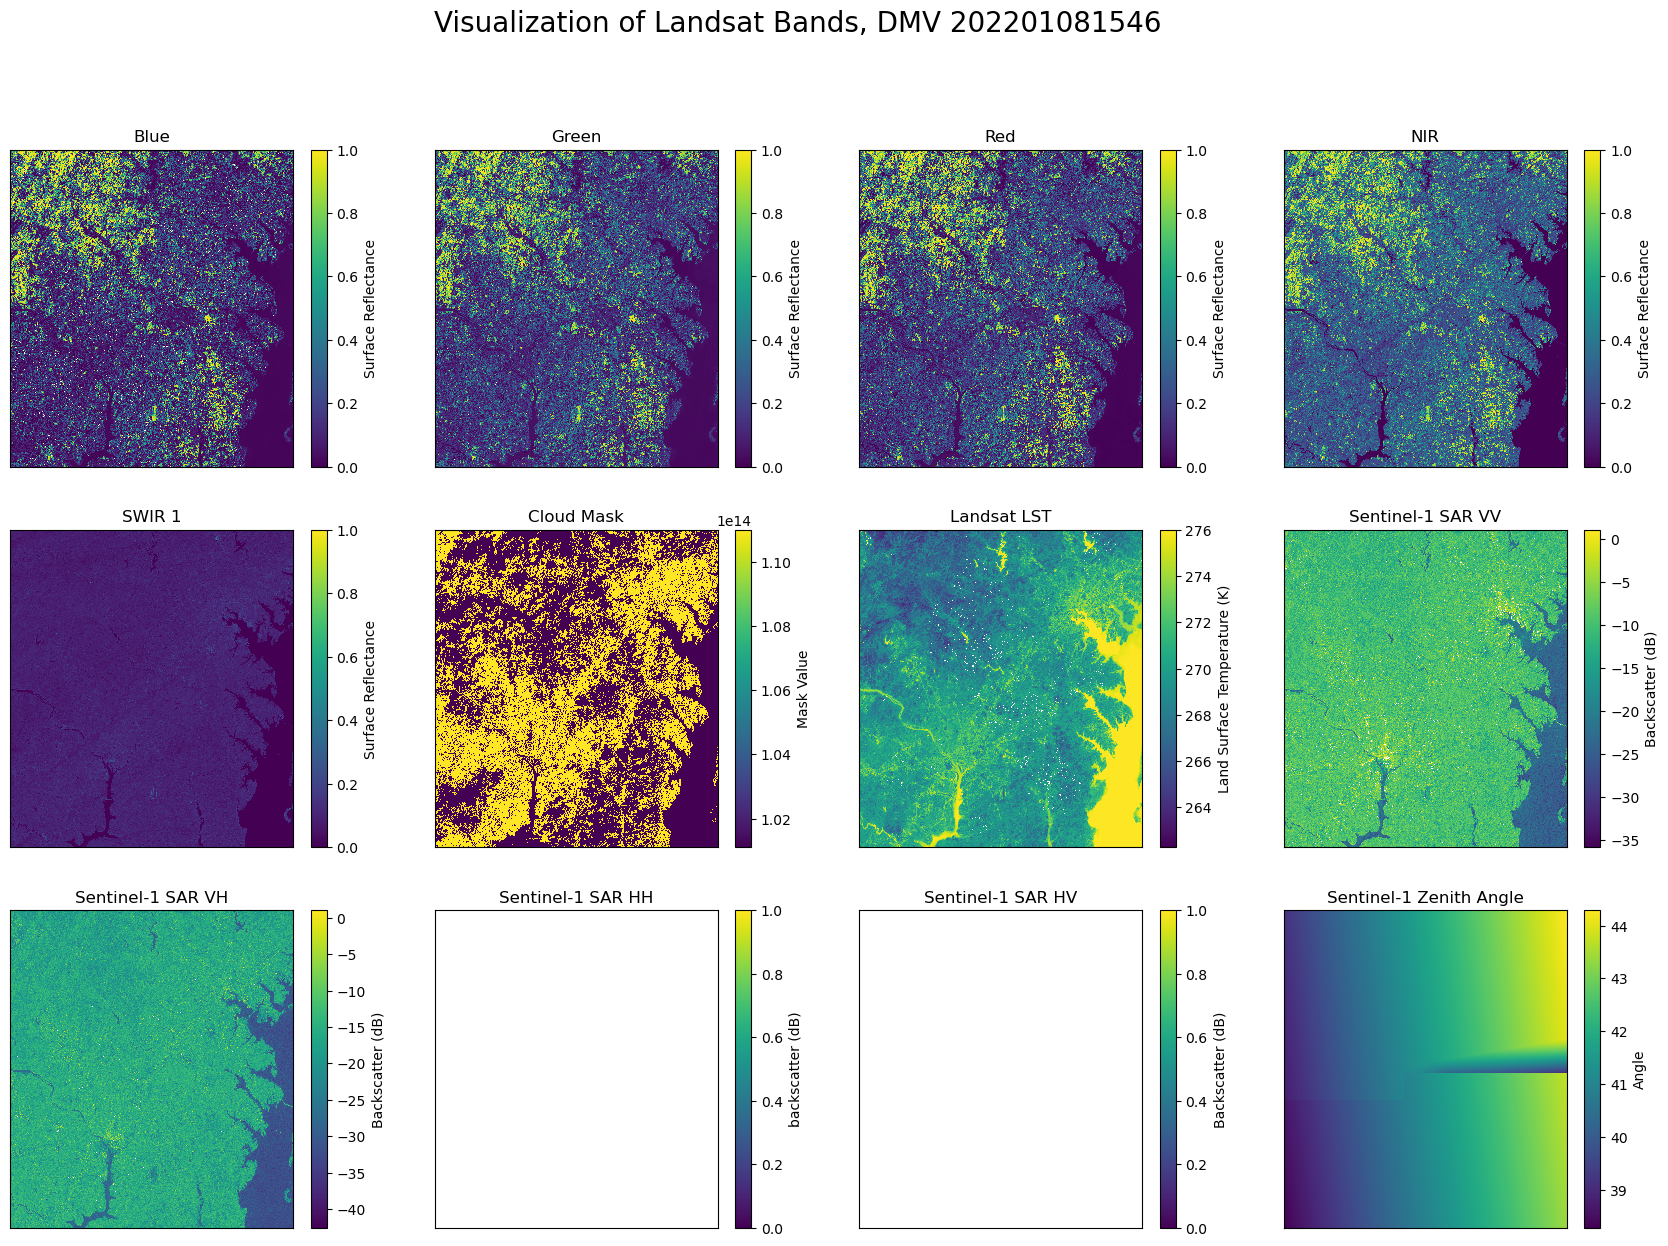

In [14]:
fig, axs = plt.subplots(3, 4)
fig.set_size_inches(21, 14)
plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])

cb = axs[0,0].pcolormesh(dsL['Landsat_blue_reflectance'], vmin=0, vmax=1)
fig.colorbar(cb, ax=axs[0,0], label='Surface Reflectance', orientation='vertical')
axs[0,0].set_title('Blue')
cb = axs[0,1].pcolormesh(dsL['Landsat_green_reflectance'], vmin=0, vmax=1)
fig.colorbar(cb, ax=axs[0,1], label='Surface Reflectance', orientation='vertical')
axs[0,1].set_title('Green')
cb = axs[0,2].pcolormesh(dsL['Landsat_red_reflectance'], vmin=0, vmax=1)
fig.colorbar(cb, ax=axs[0,2], label='Surface Reflectance', orientation='vertical')
axs[0,2].set_title('Red')
cb = axs[0,3].pcolormesh(dsL['Landsat_NIR_reflectance'], vmin=0, vmax=1)
fig.colorbar(cb, ax=axs[0,3], label='Surface Reflectance', orientation='vertical')
axs[0,3].set_title('NIR')
cb = axs[1,0].pcolormesh(dsL['Landsat_SWIR1_reflectance'], vmin=0, vmax=1)
fig.colorbar(cb, ax=axs[1,0], label='Surface Reflectance', orientation='vertical')
axs[1,0].set_title('SWIR 1')
cb = axs[1,1].pcolormesh(dsL['Landsat_cloud_mask'].values.astype(np.int64), vmin=101111000010010, vmax=111010101100000)
fig.colorbar(cb, ax=axs[1,1], label='Mask Value', orientation='vertical')
axs[1,1].set_title('Cloud Mask')
cb = axs[1,2].pcolormesh(dsL['Landsat_LST'], vmax=276)
fig.colorbar(cb, ax=axs[1,2], label='Land Surface Temperature (K)', orientation='vertical')
axs[1,2].set_title('Landsat LST')
cb = axs[1,3].pcolormesh(dsL['Sentinel1_VV'], vmax=1)
fig.colorbar(cb, ax=axs[1,3], label='Backscatter (dB)', orientation='vertical')
axs[1,3].set_title('Sentinel-1 SAR VV')
cb = axs[2,0].pcolormesh(dsL['Sentinel1_VH'], vmax=1)
fig.colorbar(cb, ax=axs[2,0], label='Backscatter (dB)', orientation='vertical')
axs[2,0].set_title('Sentinel-1 SAR VH')
cb = axs[2,1].pcolormesh(dsL['Sentinel1_HH'], vmax=1)
fig.colorbar(cb, ax=axs[2,1], label='backscatter (dB)', orientation='vertical')
axs[2,1].set_title('Sentinel-1 SAR HH')
cb = axs[2,2].pcolormesh(dsL['Sentinel1_HV'], vmax=1)
fig.colorbar(cb, ax=axs[2,2], label='Backscatter (dB)', orientation='vertical')
axs[2,2].set_title('Sentinel-1 SAR HV')
cb = axs[2,3].pcolormesh(dsL['Sentinel1_angle'])
fig.colorbar(cb, ax=axs[2,3], label='Angle', orientation='vertical')
axs[2,3].set_title('Sentinel-1 Zenith Angle')

fig.suptitle(f'Visualization of Landsat Bands, DMV 202201081546', fontsize=20)

## Train Test Split

In [4]:
cities = [
    'DMV', 'NYC', 'Phoenix', 'Miami', 'Chicago', 'Denver', 'Seattle', 'San_Francisco', 'Los_Angeles', 'Atlanta', 'Toronto',
    'Mexico_City', 'Las_Vegas', 'Salt_Lake_City', 'Dallas', 'Houston', 'New_Orleans', 'St_Louis', 'Minneapolis', 'Jacksonville',
    'Charlotte', 'Philadelphia', 'San_Diego', 'San_Juan', 'Montreal', 'Guadalajara', 'Monterrey', 'Cancun', 'Billings', 'Guatemala_City',
    'San_Jose', 'Havana', 'Santo_Domingo', 'Tegucigalpa', 'Managua', 'Panama_City', 'Bogota', 'Lima', 'Quito', 'Santiago', 'Buenos_Aires',
    'Sao_Paulo', 'Manaus', 'Punta_Arenas', 'La_Paz', 'Montevideo', 'Brasilia', 'Caracas'
]
cities = sorted(cities)

In [6]:
def index_select(nFiles):
    nums = np.arange(nFiles)
    train_indices = np.random.choice(nums, round(nFiles*0.2), replace=False)
    #test_indices = np.setdiff1d(nums, train_indices)

    return train_indices#, test_indices

In [7]:
def sort_func_Landsat(s, form=int):
    if form == int:
        return int(s.split(f'{city}_')[1].split('.nc')[0])
    else:
        return str(s.split(f'{city}_')[1].split('.nc')[0])

In [8]:
Landsat_dim = 3000
train_dim = 32
n_files_per_dim = int(np.floor(Landsat_dim/train_dim))
start_i = round((Landsat_dim-n_files_per_dim*train_dim)/2)
print(n_files_per_dim, start_i)

93 12


In [9]:
def split_func(city):
    num = len(os.listdir(dataset_root+f'/{city}/processed_Landsat')) # number of Landsat files for the city
    train_indices = index_select(num)
    train_file_list = np.array(sorted(glob.glob(dataset_root+f'/{city}/processed_Landsat/*')))[train_indices]

    LST_arrays = []
    for file in train_file_list:
        arr = xr.open_dataset(file)['Landsat_LST'].values
        LST_arrays.append(arr)
    
    LST_arrays_comb = np.stack(LST_arrays)
    LST_mean = np.nanmean(LST_arrays_comb)
    LST_std = np.nanstd(LST_arrays_comb)

    standard_array = np.array([LST_mean, LST_std])
    np.save(f'{standard_root}/{city}_mean_std.npy', standard_array)

    subprocess.call(['mkdir', '-p', f'{split_root}/{city}'])

    for file in train_file_list:
        fname = file.split('/')[-1].split('.')[0]
        LST_arr = xr.load_dataset(file)['Landsat_LST'].values
    
        for i in range(n_files_per_dim):
            #print(i)
            row = i*32+start_i
            for j in range(n_files_per_dim):
                col = j*32+start_i
                #print(row, col)
                arr = LST_arr[row:row+32, col:col+32]
                np.save(f'{split_root}/{city}/{fname}_{row}_{col}.npy', arr)

In [10]:
for city in cities:
    split_func(city)

## Get mean and std for each city

In [116]:
city = cities[31]
city

'Panama_City'

In [117]:
standard_arr = np.load(f'{standard_root}/{city}_mean_std.npy')
LST_mean = standard_arr[0]
LST_std = standard_arr[1]
print(LST_mean, LST_std)

244.00988905590984 64.7709499635817


## Model stuff

In [7]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
#from sklearn.model_selection import KFold
from torch.utils.data import Subset

In [118]:
class TrainDataset(Dataset):
    def __init__(self, img_dir, mean, std, transform=None, standardize=True):
        self.img_list = sorted(glob.glob(img_dir+'/*'))
        self.mean = mean
        self.std = std
        self.transform = transform
        self.standardize = standardize

        indices = np.arange(len(self.img_list))
        self.train_indices = np.random.choice(indices, round(len(indices)*0.8), replace=False)
        self.val_indices = np.setdiff1d(indices, self.train_indices)

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        arr = np.load(self.img_list[idx], allow_pickle=True)
        #print(self.img_list[idx])
        
        if self.standardize:
            arr = (arr-self.mean)/self.std

        #arr = np.concat([cloud, arr])
        image = torch.from_numpy(arr)
        if self.transform:
            image = self.transform(image)
            
        return torch.unsqueeze(image.to(torch.float32), 0)

In [119]:
train_dataset = TrainDataset(f'{split_root}/{city}', LST_mean, LST_std)

In [22]:
# Initialize KFold
folds = 4
kfold = KFold(n_splits=folds, shuffle=True, random_state=53)

# Split the dataset into 4 folds
for fold, (train_idx, val_idx) in enumerate(kfold.split(train_dataset)):
    print(f"Fold {fold}:")
    print(f"Train indices: {train_idx[:7]}")
    print(f"Validation indices: {val_idx[:7]}")

    # Create subsets for training and validation
    train_subset = Subset(train_dataset, train_idx)
    val_subset = Subset(train_dataset, val_idx)

    print(f"Train subset size: {len(train_subset)}, Validation subset size: {len(val_subset)}")

NameError: name 'KFold' is not defined

In [120]:
class HeatAutoencoder(nn.Module):
    def __init__(self):
        super(HeatAutoencoder, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.conv5 = nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3, padding=1)
        self.conv6 = nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3, padding=1)
        self.conv7 = nn.ConvTranspose2d(in_channels=16, out_channels=1, kernel_size=3, padding=1)

        self.norm1 = nn.BatchNorm2d(num_features=16)
        self.norm2 = nn.BatchNorm2d(num_features=32)
        self.norm3 = nn.BatchNorm2d(num_features=64)
        self.norm4 = nn.BatchNorm2d(num_features=64)
        self.norm5 = nn.BatchNorm2d(num_features=32)
        self.norm6 = nn.BatchNorm2d(num_features=16)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
        self.unpool = nn.MaxUnpool2d(kernel_size=2, stride=2)
        #self.dropout = nn.Dropout2d(0.2)

    def forward(self, x):
        x = self.conv1(x)
        x = self.norm1(x)
        x = F.relu(x)
        x, indices1 = self.pool(x)
        
        x = self.conv2(x)
        x = self.norm2(x)
        x = F.relu(x)
        x, indices2 = self.pool(x)
        #x = self.dropout(x)

        x = self.conv3(x)
        x = self.norm3(x)
        x = F.relu(x)
        x, indices3 = self.pool(x)
        
        x = self.conv4(x)
        x = self.norm4(x)
        x = F.relu(x)
        x = self.unpool(x, indices3)
        #x = self.pool(x)
        #x = self.dropout(x)

        x = self.conv5(x)
        x = self.norm5(x)
        x = F.relu(x)
        x = self.unpool(x, indices2)
            
        x = self.conv6(x)
        x = self.norm6(x)
        x = F.relu(x)
        x = self.unpool(x, indices1)
        #x = self.pool(x)
        #x = self.dropout(x)

        x = self.conv7(x)
        return x

model = HeatAutoencoder()
loss_fn = nn.MSELoss()

In [11]:
def custom_loss(outputs, features, mask):
    outputs = outputs[mask == 1]
    features = features[mask == 1]

    return loss_fn(outputs, features)

In [12]:
os.system("taskset -c -p 0-95 %d" % os.getpid())

pid 107470's current affinity list: 6-39
pid 107470's new affinity list: 6-39


0

In [13]:
cpus_avail = len(os.sched_getaffinity(0))
cpus_avail

34

In [121]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 20
batch_size = 128
early_stopping_cushion = 0
logging_interval = 1
skip_epoch_stats = False
save_model = f'/glade/derecho/scratch/jstarfeldt/autoencoder/model_saves/{city}_autoencoder.pth'
save_dict = f'/glade/derecho/scratch/jstarfeldt/autoencoder/dict_saves/{city}_loss_dict.pkl'

In [122]:
log_dict = {'train_loss_per_batch': [],
                'train_loss_per_epoch': [],
           'val_loss_per_fold': [],
           'val_loss_per_epoch': []}

In [123]:
start_time = time.time()

for epoch in range(num_epochs):
    running_train_loss = 0
    running_val_loss = 0
    
    # Create subsets for training and validation
    train_subset = Subset(train_dataset, train_dataset.train_indices)
    val_subset = Subset(train_dataset, train_dataset.val_indices)
    # Create dataloaders for the respective subset
    train_dataloader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=32)
    val_dataloader = DataLoader(val_subset, batch_size=batch_size, shuffle=False, num_workers=32)

    # Model training
    model.train()
    for batch_idx, features in enumerate(train_dataloader):
        mask = torch.where(torch.isnan(features), 0, 1)
        features = torch.nan_to_num(features, nan=0)
        # FORWARD AND BACK PROP
        logits = model(features)
        loss = custom_loss(logits, features, mask)
        optimizer.zero_grad()
        loss.backward()
        # UPDATE MODEL PARAMETERS
        optimizer.step()
        # LOGGING
        batch_loss = loss.item()
        #log_dict['train_loss_per_batch'].append(batch_loss)
        running_train_loss += batch_loss
        #if not fold % logging_interval:
        #    print('Epoch: %03d/%03d | Batch %04d/%04d | Loss: %.4f'
        #          % (epoch+1, num_epochs, batch_idx+1,
        #              len(train_dataloader), batch_loss))
    train_loss = running_train_loss/(batch_idx+1)
    # Model validation
    with torch.no_grad():
        model.eval()
        for batch_idx, features in enumerate(val_dataloader):
            mask = torch.where(torch.isnan(features), 0, 1)
            features = torch.nan_to_num(features, nan=0)
            # FORWARD AND BACK PROP
            logits = model(features)
            loss = custom_loss(logits, features, mask)
            batch_loss = loss.item()
            #log_dict['val_loss_per_fold'].append(val_loss)
            running_val_loss += batch_loss
            #print('Val Loss: %.4f'
            #          % (val_loss))
    val_loss = running_val_loss/(batch_idx+1)
    
    print('Train Loss: %.4f | Val Loss: %.4f'  % (train_loss, val_loss))

    if not skip_epoch_stats:
        with torch.set_grad_enabled(False):  # save memory during inference
            print('***Epoch: %03d/%03d | Loss: %.3f' % (
                  epoch+1, num_epochs, running_train_loss))

    torch.save(model.state_dict(), save_model) # Save model
    log_dict['train_loss_per_epoch'].append(train_loss) # Append losses
    log_dict['val_loss_per_epoch'].append(val_loss)
    with open(save_dict, 'wb') as file: # Save loss dictionary
        pickle.dump(log_dict, file)
        
    if epoch >= 2:
        if (log_dict['val_loss_per_epoch'][-2] > log_dict['val_loss_per_epoch'][-3] and
                            log_dict['val_loss_per_epoch'][-1] > log_dict['val_loss_per_epoch'][-2] + early_stopping_cushion):
            print('Early stopping')
            break
        
    print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

Train Loss: 0.0902 | Val Loss: 0.0175
***Epoch: 001/020 | Loss: 43.922
Time elapsed: 1.19 min
Train Loss: 0.0143 | Val Loss: 0.0084
***Epoch: 002/020 | Loss: 6.952
Time elapsed: 2.37 min
Train Loss: 0.0077 | Val Loss: 0.0056
***Epoch: 003/020 | Loss: 3.752
Time elapsed: 3.55 min
Train Loss: 0.0058 | Val Loss: 0.0069
***Epoch: 004/020 | Loss: 2.801
Time elapsed: 4.72 min
Train Loss: 0.0049 | Val Loss: 0.0038
***Epoch: 005/020 | Loss: 2.374
Time elapsed: 5.89 min
Train Loss: 0.0044 | Val Loss: 0.0030
***Epoch: 006/020 | Loss: 2.130
Time elapsed: 7.07 min
Train Loss: 0.0035 | Val Loss: 0.0026
***Epoch: 007/020 | Loss: 1.707
Time elapsed: 8.26 min
Train Loss: 0.0031 | Val Loss: 0.0026
***Epoch: 008/020 | Loss: 1.526
Time elapsed: 9.45 min
Train Loss: 0.0029 | Val Loss: 0.0021
***Epoch: 009/020 | Loss: 1.425
Time elapsed: 10.61 min
Train Loss: 0.0030 | Val Loss: 0.0020
***Epoch: 010/020 | Loss: 1.459
Time elapsed: 11.80 min
Train Loss: 0.0027 | Val Loss: 0.0027
***Epoch: 011/020 | Loss: 1.3

## Load model and testing

In [16]:
model.load_state_dict(torch.load(save_model, weights_only=True))

<All keys matched successfully>

In [16]:
with open(save_dict, 'rb') as file:
    log_dict = pickle.load(file)

In [113]:
#train_files_per_epoch = len(log_dict['train_loss_per_batch'])/num_epochs
train_losses = np.array(log_dict['train_loss_per_epoch'])
train_losses

array([0.10238038, 0.0276208 , 0.02588434, 0.0186949 , 0.00998565,
       0.006643  , 0.00578888, 0.00436244, 0.0043744 , 0.00344276])

In [114]:
#val_files_per_epoch = len(log_dict['val_loss_per_fold'])/num_epochs
val_losses = np.array(log_dict['val_loss_per_epoch'])
val_losses

array([0.0118678 , 0.00942695, 0.00920959, 0.00870511, 0.01203632,
       0.00373426, 0.00298411, 0.00214795, 0.00230096, 0.00280103])

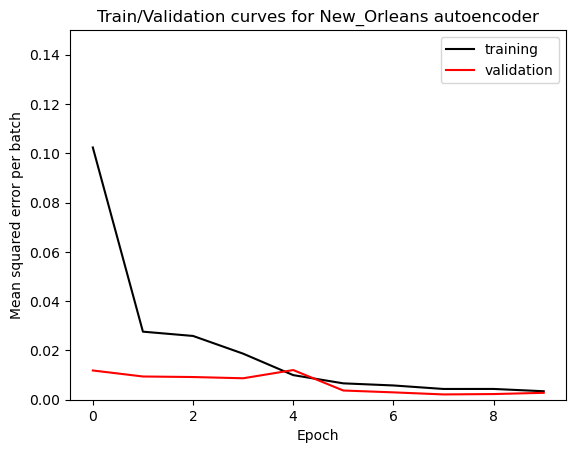

In [115]:
plt.plot(train_losses, c='k', label='training')
plt.plot(val_losses, c='r', label='validation')
plt.xlabel('Epoch')
plt.ylabel('Mean squared error per batch')
plt.ylim(0, 0.15)
plt.title(f'Train/Validation curves for {city} autoencoder')
plt.legend()
plt.show()

In [31]:
class AnalysisDataset(Dataset):
    def __init__(self, img_dir, var_mean, var_std, img_dimension=32, transform=None, standardize=True):
        self.img_list = sorted(glob.glob(img_dir+'/*'))
        self.var_mean = var_mean
        self.var_std = var_std
        self.img_dimension = img_dimension
        self.transform = transform
        self.standardize = standardize

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        ds = xr.open_dataset(self.img_list[idx])
        arr = ds['Landsat_LST'].values
        
        if self.standardize:
            arr = (arr-self.var_mean)/self.var_std

        image = torch.from_numpy(arr.astype(np.float32))
        if self.transform:
            image = self.transform(image)
            
        return image

analysis_dataset = AnalysisDataset(f'{dataset_root}/{city}/processed_Landsat', LST_mean, LST_std)

In [32]:
def get_reconstructed_data(image):
    image = torch.expand_copy(image, size=(1,1,3000,3000))

    mask = torch.where(torch.isnan(image), 0, 1)
    features = torch.nan_to_num(image, nan=0)
    # FORWARD AND BACK PROP
    logits = model(features)
    loss = custom_loss(logits, features, mask)

    a = features*LST_std + LST_mean # Reconstructed features
    b = logits*LST_std + LST_mean # Reconstructed outputs

    return a, b.detach()

In [33]:
a, b = get_reconstructed_data(analysis_dataset[4])

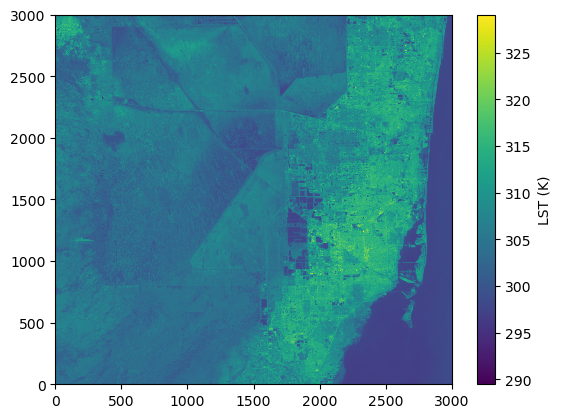

In [19]:
cb = plt.pcolormesh(a[0,0])
plt.colorbar(cb, label='LST (K)', orientation='vertical')

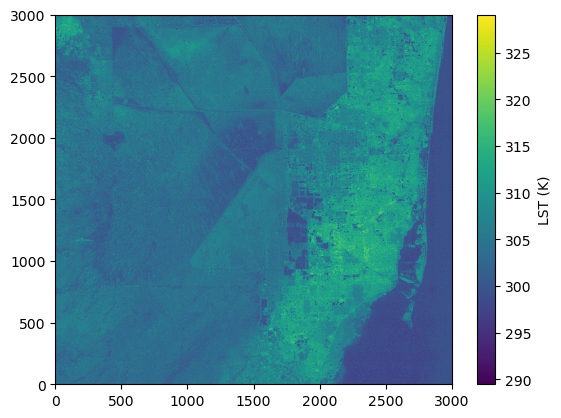

In [34]:
cb = plt.pcolormesh(b[0,0], vmin=torch.min(a[0,0]), vmax=torch.max(a[0,0]))
plt.colorbar(cb, label='LST (K)', orientation='vertical')

/glade/derecho/scratch/jstarfeldt/tmp/ipykernel_107470/1139558.py:1: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  cb = plt.pcolormesh(np.abs(a-b)[0,0], vmax=5)


Text(0.5, 1.0, 'Absolute LST Reconstruction Error')

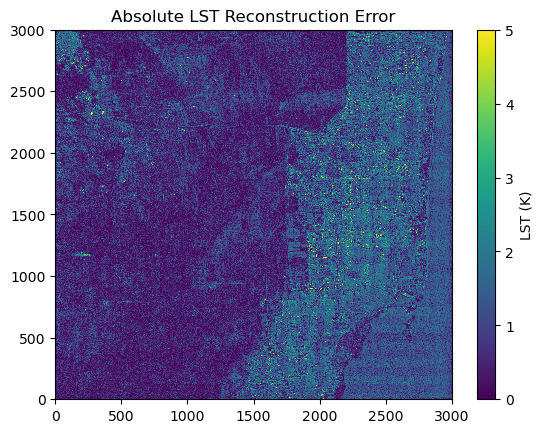

In [36]:
cb = plt.pcolormesh(np.abs(a-b)[0,0], vmax=5)
plt.colorbar(cb, label='LST (K)', orientation='vertical')
plt.title('Absolute LST Reconstruction Error')

In [110]:
reconstruction_errors = np.zeros(len(analysis_dataset))

for i in range(len(analysis_dataset)):
    a, b = get_reconstructed_data(analysis_dataset[i])
    reconstruction_errors[i] = loss_fn(a[0,0], b[0,0]).item()

In [111]:
reconstruction_errors

array([ 0.94932443,  0.59702629, 19.98972511,  3.39633203,  0.3700642 ,
        0.73826206,  0.7495088 ,  0.73971057,  0.92420584,  0.8640579 ,
        0.4625715 ,  0.59072715,  0.57738113,  0.48458466,  0.49350038,
        0.28136063, 23.42011642,  0.6143797 ,  1.89837337,  1.24073851,
       14.00448132,  9.83018303,  0.58512998,  1.20811653,  0.77125531,
       11.33668804,  0.73593891, 14.01189709,  0.61339438,  0.59831542,
        9.16074181,  3.81079245,  0.3222917 ,  0.29091111,  1.83247006])

In [ ]:
format_string = "%Y%m%d%H%M"

def file_to_dt
    #print(city)
    city_list = glob.glob(f'{dataset_root}/{city}/processed_Landsat/*')
    for file in city_list:
        #print(file)
        dt_str = file.split('_')[-1].split('.')[0]
        dt = datetime.strptime(dt_str, format_string)

In [112]:
analysis_dataset.img_list

['/glade/derecho/scratch/jstarfeldt/urban_heat_dataset/Atlanta/processed_Landsat/Landsat_Sentinel_image_Atlanta_202201041612.nc',
 '/glade/derecho/scratch/jstarfeldt/urban_heat_dataset/Atlanta/processed_Landsat/Landsat_Sentinel_image_Atlanta_202202051612.nc',
 '/glade/derecho/scratch/jstarfeldt/urban_heat_dataset/Atlanta/processed_Landsat/Landsat_Sentinel_image_Atlanta_202202211612.nc',
 '/glade/derecho/scratch/jstarfeldt/urban_heat_dataset/Atlanta/processed_Landsat/Landsat_Sentinel_image_Atlanta_202203251612.nc',
 '/glade/derecho/scratch/jstarfeldt/urban_heat_dataset/Atlanta/processed_Landsat/Landsat_Sentinel_image_Atlanta_202204101612.nc',
 '/glade/derecho/scratch/jstarfeldt/urban_heat_dataset/Atlanta/processed_Landsat/Landsat_Sentinel_image_Atlanta_202205121612.nc',
 '/glade/derecho/scratch/jstarfeldt/urban_heat_dataset/Atlanta/processed_Landsat/Landsat_Sentinel_image_Atlanta_202205281612.nc',
 '/glade/derecho/scratch/jstarfeldt/urban_heat_dataset/Atlanta/processed_Landsat/Landsat_S